In [2]:
import json
import math
from collections import namedtuple
from typing import Any, Dict, List

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm, tnrange
from numpy import typing as npt
from tensorflow import keras
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd


In [3]:
counter = 0


In [4]:
def load_glow(hps_path: str) -> None:
    hps: Dict[str, Any]
    with open(hps_path, "r") as json_file:
        hps = json.load(json_file)

    glow = tfb.Glow(
        output_shape=hps["OUTPUT_SHAPE"],
        num_glow_blocks=hps["NUM_GLOW_BLOCKS"],
        num_steps_per_block=hps["NUM_STEPS_PER_BLOCK"],
        coupling_bijector_fn=tfb.GlowDefaultNetwork,
        exit_bijector_fn=tfb.GlowDefaultExitNetwork,
        grab_after_block=hps["GRAB_AFTER_BLOCK"],
        use_actnorm=hps["USE_ACTNORM"],
        seed=hps["SEED"],
        validate_args=True,
    )

    z_shape = glow.inverse_event_shape(hps["OUTPUT_SHAPE"])
    pz = tfd.Sample(tfd.Normal(0.0, 1.0), z_shape)
    px = glow(pz)

    checkpoint = tf.train.Checkpoint(glow)

    checkpoint_path = (
        f"{hps['CHECKPOINT_DIR']}-{math.floor(hps['EPOCHS'] / hps['CHECKPOINT_FREQ']) + 1}"
    )
    status = checkpoint.restore(checkpoint_path)
    status.assert_consumed().assert_existing_objects_matched().assert_nontrivial_match()

    print(f"Loaded: {checkpoint_path}")

    return glow, pz, px, hps


In [5]:
# glow, pz, px, hps = load_glow("/home/lukas/HESSENBOX-DA/Bachelor-Thesis/Ergebnisse/TFP GLOW/64-1_2022-09-05_05:59:46/hyperparameters.json")
glow, pz, px, hps = load_glow(
    "/home/lukas/HESSENBOX-DA/Bachelor-Thesis/Ergebnisse/TFP GLOW/128-2_2022-09-20_17:36:27/hyperparameters.json"
)


2022-10-14 10:07:54.100294: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 10:07:54.141672: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-10-14 10:07:55.831290: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Loaded: /home/lukas/HESSENBOX-DA/Bachelor-Thesis/Ergebnisse/TFP GLOW/128-2_2022-09-20_17:36:27/checkpoints/ckpt-11


In [6]:
def load_image(path: str) -> tf.Tensor:
    return tf.convert_to_tensor(keras.utils.img_to_array(keras.utils.load_img(path)))


In [7]:
def preprocess(tensor: tf.Tensor) -> tf.Tensor:
    tensor = tf.cast(tensor, tf.float32)
    tensor = tf.image.central_crop(tensor, hps["CENTRAL_CROP_FRACTION"])
    tensor = tf.image.resize(tensor, (hps["IMAGE_SIZE"], hps["IMAGE_SIZE"]))

    tensor = tensor / 255 - 0.5
    return tensor


In [15]:
def depreprocess(tensor: tf.Tensor) -> tf.Tensor:
    print(f"{tf.reduce_min(tensor):.3f}, {tf.reduce_max(tensor):.3f}")
    return tf.clip_by_value(tensor + 0.5, 0.0, 1.0)


In [10]:
img1 = load_image(
    "/home/lukas/Documents/bachelor-thesis/bachelor_thesis/tfp-glow/evaluation/images/Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0002_36648.jpg"
)
img1 = preprocess(img1)

img2 = load_image(
    "/home/lukas/Documents/bachelor-thesis/bachelor_thesis/tfp-glow/evaluation/images/Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0014_36708.jpg"
)
img2 = preprocess(img2)

img3 = load_image(
    "/home/lukas/Documents/bachelor-thesis/bachelor_thesis/tfp-glow/evaluation/images/Bird/Icteridae/Scott_Oriole/Scott_Oriole_0010_795852.jpg"
)
img3 = preprocess(img3)

img4 = load_image(
    "/home/lukas/Documents/bachelor-thesis/bachelor_thesis/tfp-glow/evaluation/images/Bird/Icteridae/Bobolink/Bobolink_0049_9540.jpg"
)
img4 = preprocess(img4)


tf.Tensor(-0.4993523, shape=(), dtype=float32) tf.Tensor(0.4923694, shape=(), dtype=float32)
tf.Tensor(-0.5, shape=(), dtype=float32) tf.Tensor(0.4934436, shape=(), dtype=float32)
tf.Tensor(-0.5, shape=(), dtype=float32) tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(-0.5, shape=(), dtype=float32) tf.Tensor(0.49951744, shape=(), dtype=float32)


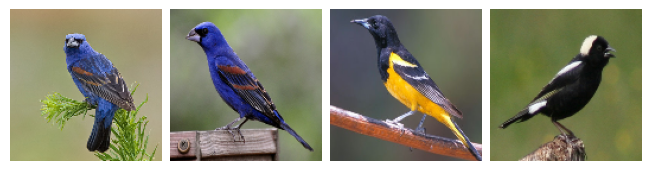

In [11]:
fig, axs = plt.subplots(1, 4, dpi=100, constrained_layout=True)

for img, ax in zip([img1, img2, img3, img4], axs):
    ax.imshow(depreprocess(img))
    ax.set_axis_off()

plt.show()


In [20]:
z1 = glow.inverse(tf.expand_dims(img4, 0))

z_shape = glow.inverse_event_shape(hps["OUTPUT_SHAPE"])

ztake = [
    round(bs[1] * 4 ** (i + math.log2(hps["IMAGE_SIZE"]) - hps["NUM_GLOW_BLOCKS"]))
    for i, bs in enumerate(glow.blockwise_splits)
]
total_z_taken = sum(ztake)
split_sizes = [z_shape.as_list()[0] - total_z_taken] + ztake
zsplits = tf.split(z1, num_or_size_splits=split_sizes, axis=-1)

print(f"[s.shape for s in zsplits]: {[s.shape for s in zsplits]}")


[s.shape for s in zsplits]: [TensorShape([1, 1536]), TensorShape([1, 0]), TensorShape([1, 1536]), TensorShape([1, 3072]), TensorShape([1, 6144]), TensorShape([1, 12288]), TensorShape([1, 24576])]


In [21]:
rebuild = tf.concat(zsplits, 1)

print(rebuild.shape)
print(tf.reduce_all(rebuild == z1))


(1, 49152)
tf.Tensor(True, shape=(), dtype=bool)


In [22]:
x1 = glow(rebuild)


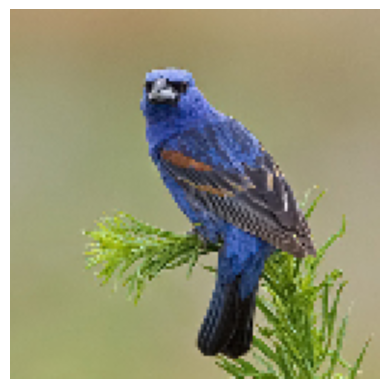

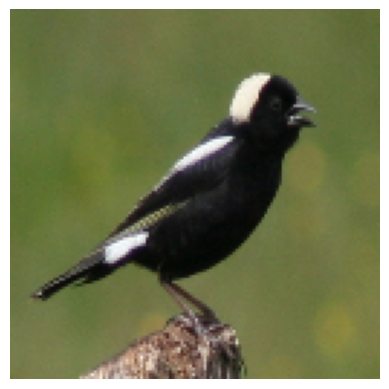

(128, 128, 3) (128, 128, 3)
tf.Tensor(0.163656, shape=(), dtype=float32)


In [23]:
plt.imshow(depreprocess(img1))
plt.gca().set_axis_off()

plt.figure()

plt.imshow(depreprocess(x1[0]))
plt.gca().set_axis_off()

plt.show()

print(img1.shape, x1[0].shape)
print(tf.reduce_mean(img1 - x1[0]))


In [24]:
# resampled_50 = tf.concat(
#     [zsplits[0], zsplits[1], zsplits[2], zsplits[3], tf.zeros_like(zsplits[4])], 1
# )
# resampled_25 = tf.concat(
#     [zsplits[0], zsplits[1], zsplits[2], tf.zeros_like(zsplits[3]), tf.zeros_like(zsplits[4])], 1
# )
# resampled_13 = tf.concat(
#     [
#         zsplits[0],
#         zsplits[1],
#         tf.zeros_like(zsplits[2]),
#         tf.zeros_like(zsplits[3]),
#         tf.zeros_like(zsplits[4]),
#     ],
#     1,
# )

# # Currently we are not resampling but setting to 0
# # tf.random.normal(zsplits[4].shape)

# print(resampled_50.shape)
# print(resampled_25.shape)
# print(resampled_13.shape)
# print(tf.reduce_all(resampled_50 == z1))


In [11]:
blocks = hps["NUM_GLOW_BLOCKS"]

resamples = []

for i in range(blocks):
    splits = []
    for j in range(len(zsplits)):
        if blocks - i > j - 1:
            splits.append(1)
        else:
            splits.append(0)

    resamples.append(splits)

print(resamples)


[[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0, 0]]


In [25]:
blocks = hps["NUM_GLOW_BLOCKS"]

resamples = []

for i in range(blocks):
    splits = []
    for j in range(len(zsplits)):
        if blocks - i > j - 1:
            splits.append(zsplits[j])
        else:
            splits.append(tf.zeros_like(zsplits[j]))

    resamples.append(tf.concat(splits, 1))


In [26]:
xis = []

for resample in tqdm(resamples):
    xis.append(glow(resample))


  0%|          | 0/6 [00:00<?, ?it/s]

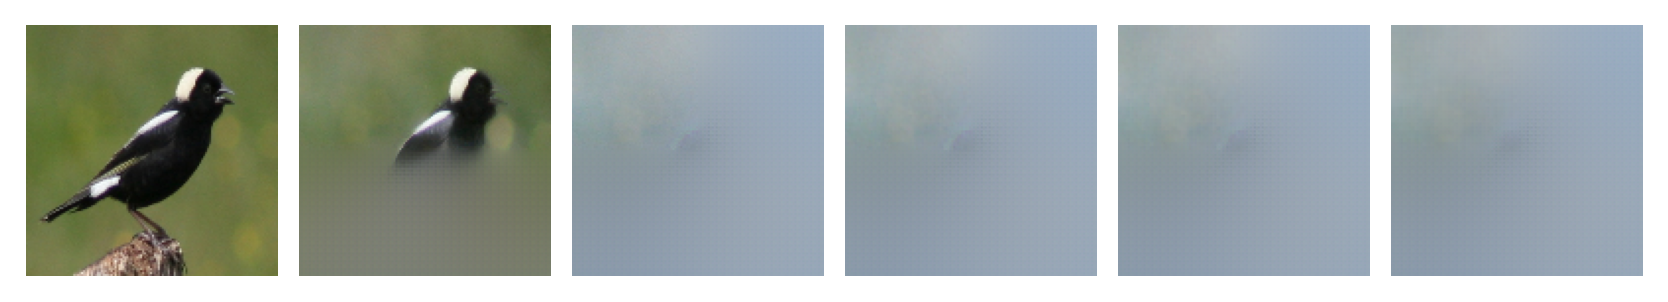

In [27]:
fig, axs = plt.subplots(1, len(xis), dpi=256, constrained_layout=True)

for img, ax in zip(xis, axs):
    keras.utils.save_img(f"out/{counter}.png", depreprocess(img[0]).numpy() * 255, scale=False)
    counter += 1

    ax.imshow(depreprocess(img[0]))
    ax.set_axis_off()

plt.show()


In [12]:
resamples_alt = []

for i in range(blocks):
    splits = []
    for j in range(len(zsplits)):
        if i < j - 1:
            splits.append(1)
        else:
            splits.append(0)

    resamples_alt.append(splits)

print(resamples_alt)

[[0, 0, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0]]


In [76]:
resamples_alt = []

for i in range(blocks):
    splits = []
    for j in range(len(zsplits)):
        if i < j - 1:
            splits.append(zsplits[j])
            # splits.append(1)
        else:
            splits.append(tf.zeros_like(zsplits[j]))
            # splits.append(0)

    resamples_alt.append(tf.concat(splits, 1))
    # resamples_alt.append(splits)

# print(resamples_alt)


In [77]:
xis_alt = []

for resample in tqdm(resamples_alt):
    xis_alt.append(glow(resample))


  0%|          | 0/6 [00:00<?, ?it/s]

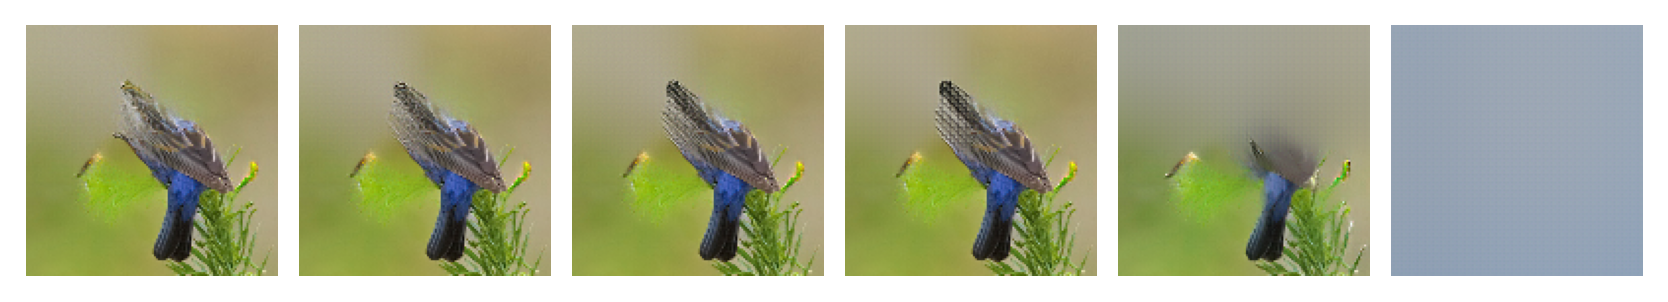

In [78]:
fig, axs = plt.subplots(1, len(xis_alt), dpi=256, constrained_layout=True)

for img, ax in zip(xis_alt, axs):
    keras.utils.save_img(f"out/{counter}.png", depreprocess(img[0]).numpy() * 255, scale=False)
    counter += 1

    ax.imshow(depreprocess(img[0]))
    ax.set_axis_off()

plt.show()


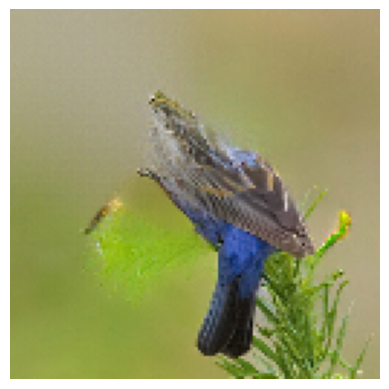

In [79]:
resampled = tf.concat(
    [
        tf.zeros_like(zsplits[0]),
        zsplits[1],
        zsplits[2],
        zsplits[3],
        zsplits[4],
        zsplits[5],
        zsplits[6],
    ],
    1,
)
xi = glow(resampled)

plt.imshow(depreprocess(xi[0]))
plt.gca().set_axis_off()

plt.show()


In [80]:
# xi_1 = glow(resampled_50)
# xi_2 = glow(resampled_25)
# xi_3 = glow(resampled_13)


In [81]:
# fig, axs = plt.subplots(1, 4, dpi=256, constrained_layout=True)

# for img, ax in zip([x1, xi_1, xi_2, xi_3], axs):
#     ax.imshow(depreprocess(img[0]))
#     ax.set_axis_off()

# plt.show()


In [82]:
rev = depreprocess(glow(tf.reverse(glow.inverse(tf.expand_dims(img1, 0)), [0]))[0])


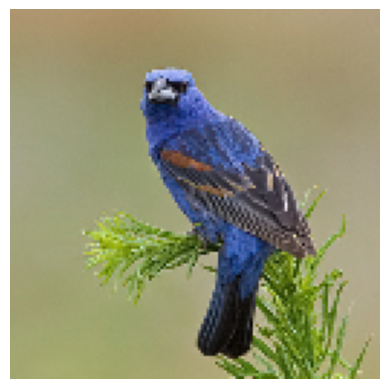

In [83]:
plt.imshow(rev)
plt.gca().set_axis_off()

plt.show()


In [84]:
print(tf.reduce_all(rev == img1))

print(tf.reduce_mean(rev - img1))


tf.Tensor(False, shape=(), dtype=bool)
tf.Tensor(0.49999747, shape=(), dtype=float32)


In [19]:
n = 3

z = glow.inverse(tf.expand_dims(img1, 0))
shuffles = [tf.expand_dims(tf.random.shuffle(z[0]), 0) for _ in range(n)]

print([tf.keras.losses.MeanSquaredError()(shuffles[i], shuffles[i + 1]).numpy() for i in range(n - 1)])

shuffled_images = [depreprocess(glow(s)) for s in shuffles]


[1.4696964, 1.4537945]
-0.527, 0.575
-0.567, 0.624
-0.525, 0.490


In [20]:
print(z.shape)
print(shuffles[0].shape)

(1, 49152)
(1, 49152)


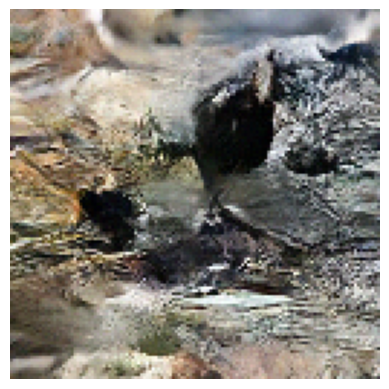

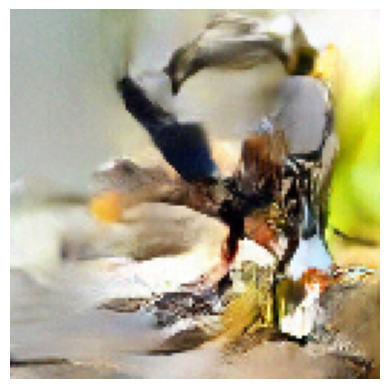

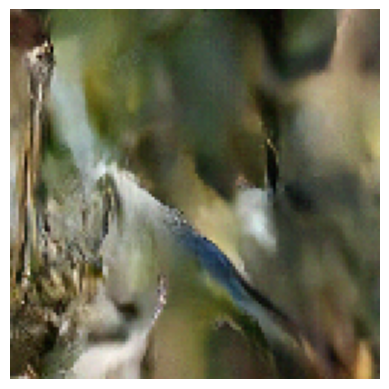

In [22]:

for s in shuffled_images:
    plt.figure()
    plt.imshow(s[0])
    plt.gca().set_axis_off()

plt.show()

In [17]:
blocks = hps["NUM_GLOW_BLOCKS"]

resamples = []

for i in range(blocks):
    splits = []
    for j in range(len(zsplits)):
        if blocks - i > j - 1:
            splits.append(zsplits[j])
        else:
            splits.append(tf.random.normal(zsplits[j].shape, stddev=0.5))

    resamples.append(tf.concat(splits, 1))

In [18]:
xis = []

for resample in tqdm(resamples):
    xis.append(glow(resample))

  0%|          | 0/6 [00:00<?, ?it/s]

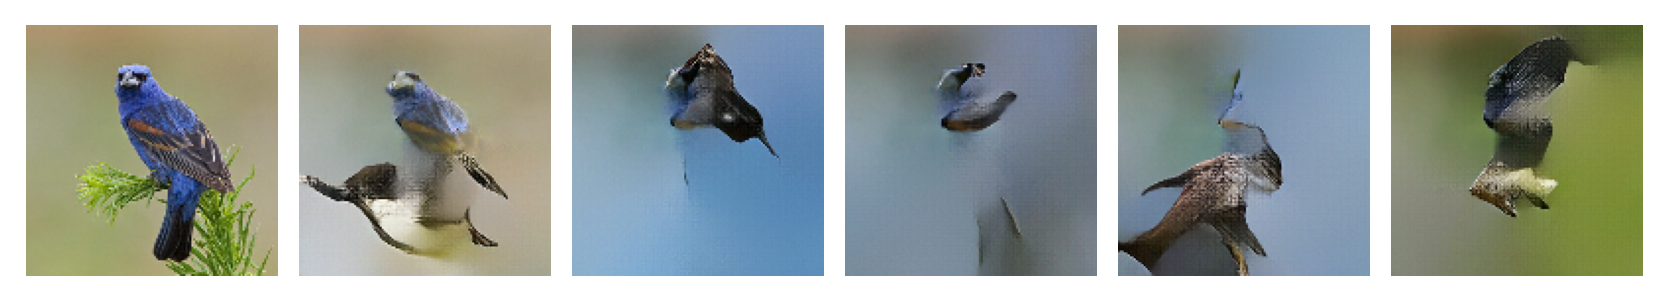

In [19]:
fig, axs = plt.subplots(1, len(xis), dpi=256, constrained_layout=True)

for img, ax in zip(xis, axs):
    keras.utils.save_img(f"out/{counter}.png", depreprocess(img[0]).numpy() * 255, scale=False)
    counter += 1

    ax.imshow(depreprocess(img[0]))
    ax.set_axis_off()

plt.show()